In [0]:
import torch 
from torchvision import datasets, transforms 

batch_size = 64 
num_workers = 0

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
traindata = datasets.SVHN('traindata', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=batch_size, num_workers=0)

Using downloaded and verified file: traindata/train_32x32.mat


torch.Size([64, 3, 32, 32])


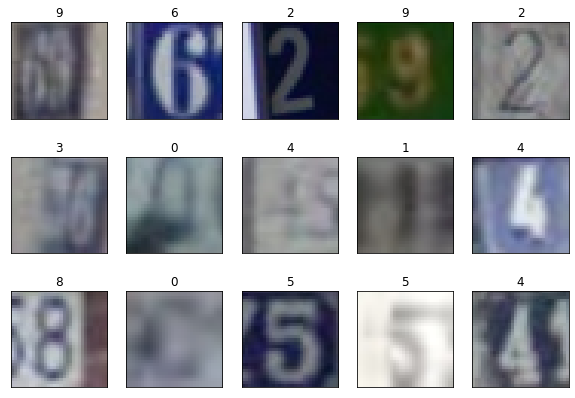

In [0]:
# Visualize data 
import matplotlib.pyplot as plt 
import numpy as np 
%matplotlib inline 

images, labels = next(iter(trainloader))
print(images.shape)

fig, axes = plt.subplots(3, 5, figsize=(10, 7))

for ax, i in zip(axes.flatten(), np.arange(15)):
  img = np.transpose(images[i]/2 + 0.5, (1, 2, 0))
  ax.imshow(img)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  ax.set_title(str(labels[i].item()))

In [0]:
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


In [0]:
# Define the discriminator model 
import torch.nn as nn 
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))

  return nn.Sequential(*layers)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = conv(3, 32, 4, batch_norm=False)
    self.conv2 = conv(32, 64, 4)
    self.conv3 = conv(64, 128, 4)

    self.fc1 = nn.Linear(128*4*4, 1)

  def forward(self, x):

    x = F.leaky_relu(self.conv1(x))
    x = F.leaky_relu(self.conv2(x)) 
    x = F.leaky_relu(self.conv3(x))
    x = x.view(-1, 128*4*4)
    x = self.fc1(x)

    return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(device)
print(D)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)


In [0]:
# Define the Generator model 
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

  layers = []
  deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(deconv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

class Generator(nn.Module):
  def __init__(self, z_size):
    super().__init__()

    self.fc = nn.Linear(z_size, 128*4*4)

    self.deconv1 = deconv(128, 64, 4)
    self.deconv2 = deconv(64, 32, 4)
    self.deconv3 = deconv(32, 3, 4)
  
  def forward(self, z_size):

    x = self.fc(z_size)
    x = x.view(-1, 128, 4, 4)
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = torch.tanh(self.deconv3(x))

    return x 

z_size = 100 
G = Generator(z_size).to(device)
print(G)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [0]:
# Define loss 

def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9
  else:
    labels = torch.ones(batch_size)
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss 

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size).to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)
  return loss 

In [0]:
# Define the optimizer 

import torch.optim as optim 

beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr=0.002, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr=0.002, betas=(beta1, beta2))

In [0]:
num_epoch = 50 
sample_size = 16
print_every = 300

losses = []
samples = []

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

D.train()
G.train()

for epoch in range(num_epoch):

  for batch_i, (real_images, _) in enumerate(trainloader):
    
    batch_size = real_images.size(0)
    real_images = real_images.to(device)

    ########################
    # TRAIN DISCRIMINATOR  #
    ########################

    D.zero_grad()
    D_real = D(real_images).to(device)
    d_real_loss = real_loss(D_real, smooth=True).to(device)

    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = G(z).to(device)

    D_fake = D(fake_images).to(device)
    d_fake_loss = fake_loss(D_fake).to(device)

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    ####################
    # TRAIN GENERATOR  #
    ####################

    G.zero_grad()

    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = G(z).to(device)

    D_fake = D(fake_images).to(device)
    g_loss = real_loss(D_fake).to(device)

    g_loss.backward()
    g_optimizer.step()

    if batch_i % print_every == 0: 
      print("EPOCH [{:5d}/{:5d}] | d_loss : {:6.4f} | g_loss : {:6.4f}.".format(epoch+1, num_epoch, d_loss.item(), g_loss.item()))
  
  losses.append((d_loss.item(), g_loss.item()))

  G.eval()
  sample = G(fixed_z)
  samples.append(sample)
  G.train()



EPOCH [    1/   50] | d_loss : 1.4089 | g_loss : 3.3740.
EPOCH [    1/   50] | d_loss : 1.1917 | g_loss : 1.1296.
EPOCH [    1/   50] | d_loss : 1.1627 | g_loss : 1.2002.
EPOCH [    1/   50] | d_loss : 1.2873 | g_loss : 1.1233.
EPOCH [    2/   50] | d_loss : 1.1340 | g_loss : 1.7990.
EPOCH [    2/   50] | d_loss : 1.0614 | g_loss : 1.2079.
EPOCH [    2/   50] | d_loss : 0.8684 | g_loss : 2.1174.
EPOCH [    2/   50] | d_loss : 0.7514 | g_loss : 2.7912.
EPOCH [    3/   50] | d_loss : 0.9985 | g_loss : 1.7816.
EPOCH [    3/   50] | d_loss : 0.7027 | g_loss : 1.8867.
EPOCH [    3/   50] | d_loss : 0.8083 | g_loss : 1.3919.
EPOCH [    3/   50] | d_loss : 0.5552 | g_loss : 2.5774.
EPOCH [    4/   50] | d_loss : 0.6417 | g_loss : 3.0602.
EPOCH [    4/   50] | d_loss : 1.0715 | g_loss : 1.4106.
EPOCH [    4/   50] | d_loss : 0.8688 | g_loss : 2.7729.
EPOCH [    4/   50] | d_loss : 0.6146 | g_loss : 2.6152.
EPOCH [    5/   50] | d_loss : 0.6137 | g_loss : 2.9281.
EPOCH [    5/   50] | d_loss : 

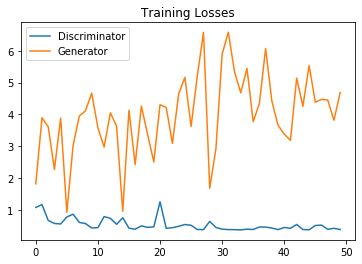

In [0]:
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()

In [0]:
import pickle as pkl

with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)

In [0]:
from google.colab import drive 

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np 

with open('train_samples.pkl', 'rb') as f:
  samples = pkl.load(f)

def view_samples(epoch):
  fig, axes = plt.subplots(4, 4, figsize=(7, 7))
  for ax, sample in zip(axes.flatten(), samples[epoch]):
    sample = sample.detach().cpu()
    sample = np.transpose(sample/2 + 0.5, (1, 2, 0))
    ax.imshow(sample)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

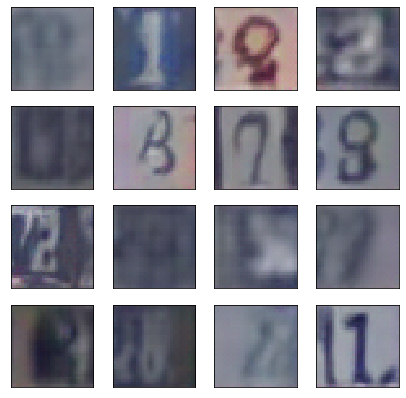

In [0]:
view_samples(-1)

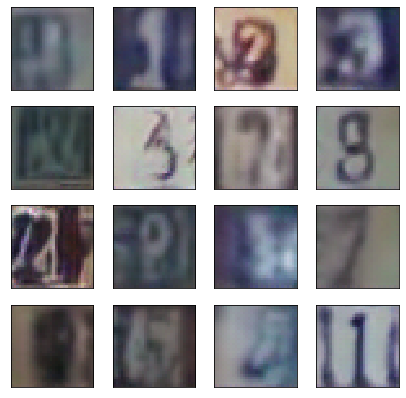

In [0]:
view_samples(28)